In [38]:
import jaydebeapi
                               
jdbeurl = "jdbc:gs://127.0.0.1:20001/myCluster/public"
jdbeconn = jaydebeapi.connect("com.toshiba.mwcloud.gs.sql.Driver", jdbeurl, ["admin", "admin"], "./gridstore-jdbc.jar")

jdbecurs = jdbeconn.cursor()
jdbecurs.execute("SELECT ts FROM device2 limit 1")
rows = jdbecurs.fetchall()
print(type(rows[0][0]), rows[0][0])

<class 'str'> 2020-07-11 17:01:34.735000


In [39]:
import jpype
import jpype.dbapi2
    
url = "jdbc:gs://127.0.0.1:20001/myCluster/public"
conn = jpype.dbapi2.connect(url, driver="com.toshiba.mwcloud.gs.sql.Driver", driver_args={"user": "admin", "password": "admin"})

curs = conn.cursor()
curs.execute("SELECT ts FROM device2 limit 1")
rows = curs.fetchall()
print(type(rows[0][0]), rows[0][0])

<class 'datetime.datetime'> 2020-07-11 17:01:34.735000


In [42]:
import datetime
import pandas as pd

def getRange(conn, table, range):
    curs = conn.cursor()
    curs.execute("SELECT min(ts),max(ts) from "+table)
    rows = curs.fetchall()
    start = rows[0][0];
    end = rows[0][1]

    curs.execute("""select * from """+table+""" where ts >= TO_TIMESTAMP_MS("""+str(int(start.timestamp()*1000))+""") 
                 and ts <= TO_TIMESTAMP_MS("""+str(int(end.timestamp()*1000))+""") group by range (ts) EVERY (1, """+range+""");""");

    cols = tuple(zip(*curs.description))[0]
    df = pd.DataFrame(curs.fetchall(), columns=cols)
    return df

getRange(conn, "device2", "DAY")

,ts,co,humidity,light,lpg,motion,smoke,temp
0,2020-07-11 17:00:00,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
1,2020-07-12 17:00:00,0.011738,73.900002,False,0.014276,False,0.039740,18.900000
2,2020-07-13 17:00:00,0.004167,74.300003,False,0.006749,False,0.017851,19.000000
3,2020-07-14 17:00:00,0.004577,73.699997,False,0.007222,False,0.019193,18.900000
4,2020-07-15 17:00:00,0.008437,73.599998,False,0.011243,False,0.030792,18.700001
5,2020-07-16 17:00:00,0.002350,74.800003,False,0.004459,False,0.011467,19.700001
6,2020-07-17 17:00:00,0.004816,76.500000,False,0.007494,False,0.019964,18.900000
7,2020-07-18 17:00:00,0.004878,77.099998,False,0.007563,False,0.020162,19.200001
8,2020-07-19 17:00:00,0.003700,75.599998,False,0.006193,False,0.016285,19.299999


In [43]:
def getAggregates(conn, table, agg, column, range):
    curs = conn.cursor()
    curs.execute("SELECT min(ts),max(ts) from "+table)
    rows = curs.fetchall()
    start = rows[0][0];
    end=rows[0][1]

    curs.execute("""select ts,"""+agg+"("+column+") from "+table+" where ts >= TO_TIMESTAMP_MS("+str(int(start.timestamp()*1000))+""") 
                 and ts <= TO_TIMESTAMP_MS("""+str(int(end.timestamp()*1000))+") group by range (ts) EVERY (1, "+range+");");

    df = pd.DataFrame(curs.fetchall(), columns=("ts", column))
    return df

getAggregates(conn, "device2", "min", "humidity", "DAY")

,ts,humidity
0,2020-07-11 17:00:00,21.600000
1,2020-07-12 17:00:00,22.900000
2,2020-07-13 17:00:00,22.100000
3,2020-07-14 17:00:00,22.100000
4,2020-07-15 17:00:00,21.400000
5,2020-07-16 17:00:00,23.799999
6,2020-07-17 17:00:00,24.299999
7,2020-07-18 17:00:00,1.100000
8,2020-07-19 17:00:00,75.300003


In [48]:
getAggregates(conn, "device2", "max", "motion", "DAY")

,ts,motion
0,2020-07-11 17:00:00,False
1,2020-07-12 17:00:00,False
2,2020-07-13 17:00:00,False
3,2020-07-14 17:00:00,False
4,2020-07-15 17:00:00,True
5,2020-07-16 17:00:00,False
6,2020-07-17 17:00:00,False
7,2020-07-18 17:00:00,True
8,2020-07-19 17:00:00,False


In [23]:
def getBoolCount(conn, table, column, range):
    curs = conn.cursor()
    curs.execute("SELECT min(ts),max(ts) from "+table)
    rows = curs.fetchall()
    start = rows[0][0];
    end=rows[0][1]

    curs.execute("select ts,count("+column+") from "+table+" where ts >= TO_TIMESTAMP_MS("+str(int(start.timestamp()*1000))+""")
                  and ts <= TO_TIMESTAMP_MS("""+str(int(end.timestamp()*1000))+") and "+column+" group by range (ts) EVERY (1, "+range+");");

    df = pd.DataFrame(curs.fetchall(), columns=("ts", column))
    return df
    
getBoolCount(conn, "device2", "motion", "DAY")

,ts,motion
0,2020-07-11 17:00:00,NaN
1,2020-07-12 17:00:00,NaN
2,2020-07-13 17:00:00,NaN
3,2020-07-14 17:00:00,NaN
4,2020-07-15 17:00:00,2.0
5,2020-07-16 17:00:00,NaN
6,2020-07-17 17:00:00,NaN
7,2020-07-18 17:00:00,1.0
8,2020-07-19 17:00:00,NaN


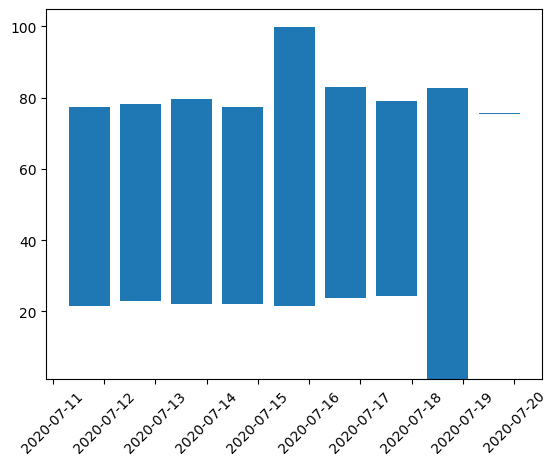

In [46]:
import matplotlib.pyplot as plt


mins = getAggregates(conn, "device2", "min", "humidity", "DAY")
maxes = getAggregates(conn, "device2", "max", "humidity", "DAY")

plt.bar(mins['ts'], maxes["humidity"]-mins["humidity"], bottom=mins["humidity"]);
plt.xticks(rotation = 45);


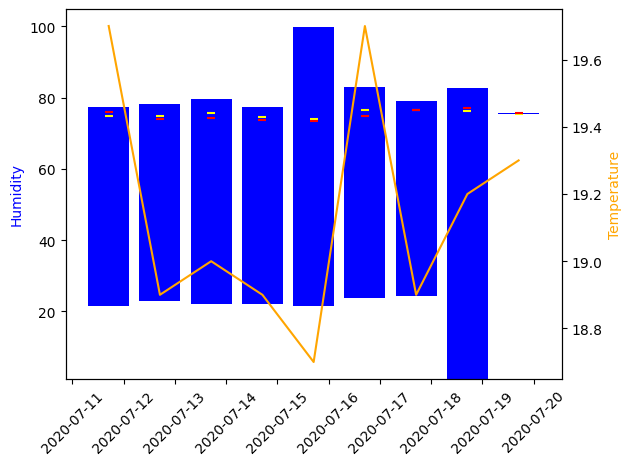

In [57]:
mins = getAggregates(conn, "device2", "min", "humidity", "DAY")
maxes = getAggregates(conn, "device2", "max", "humidity", "DAY")
avgs = getAggregates(conn, "device2", "avg", "humidity", "DAY")
all = getRange(conn, "device2", "DAY")

plt.bar(mins['ts'], maxes["humidity"]-mins["humidity"], bottom=mins["humidity"], color='blue')
plt.scatter(x=avgs['ts'], y=avgs['humidity'], color='yellow', marker='_')
plt.scatter(x=all['ts'], y=all['humidity'], color='red', marker='_')
plt.xticks(rotation = 45);
plt.ylabel('Humidity', color='blue')

plt2 = plt.twinx()
plt2.plot(all['ts'],  all['temp'], color='orange')
plt2.set_ylabel('Temperature', color='orange');